# Reddit Project EDA Script
## Yongrui Chen 
## yc910@georgetown.edu

### Reading the entire dataset

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark.sql.functions as f
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("reddit").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/02 19:33:34 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
22/04/02 19:33:42 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


Make sure your SparkSession is active:

In [4]:
spark

In [5]:
df_full = spark.read.parquet('s3://yc910-labdata-2/reddit')

In [6]:
df_full.count()

22/04/02 19:33:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


12904319

## 1. Basic Info about the Data of #PoliticalCompassMemes
Report on the basic info about your dataset. What are the interesting columns? What is the schema? How many rows do you have? etc. etc.

### Answer: 
The date has 12904319 rows and 51 columns in total, and the most interesting colunmns are `author`, `author_created_utc`, `author_premium`, `author_flair_text`, `author_fullname`, `body`, `collapsed`, `collapsed_reason`, `controversiality`, `created_utc`, `distinguished`, `gilded`, `no_follow`, `quarantined`, `removal_reason`, `score`, `send_replies`, `top_awarded_type`, `total_awards_received`. 

Most of the columns are either string type or boolean type, and the string columns are always descriptive variables, while the boolean columns are some features about the authors and the posts.

In [7]:
## Check the data
df_full.limit(5).toPandas().T

,0,1,2,3,4
all_awardings,[],[],[],[],[]
associated_award,None,None,None,None,None
author,[deleted],AlbionPrince,KillerofBrainCells,hiimirony,[deleted]
author_created_utc,NaN,1599310247.0,1586831905.0,1378536635.0,NaN
author_flair_background_color,,transparent,transparent,transparent,
author_flair_css_class,None,None,None,None,None
author_flair_richtext,nan,"[{'a': ':CENTG:', 'e': 'emoji', 'u': 'https://...","[{'a': ':left:', 'e': 'emoji', 'u': 'https://e...","[{'a': ':libleft:', 'e': 'emoji', 'u': 'https:...",nan
author_flair_template_id,None,46901708-bd3d-11ea-9a8a-0e03ab8df87b,32035b7c-e950-11e9-9aae-0e7bbe7acab2,47a39016-e94e-11e9-9211-0e435e52671c,None
author_flair_text,None,:CENTG: - Centrist,:left: - Left,:libleft: - LibLeft,None
author_flair_text_color,dark,dark,dark,dark,dark


In [8]:
print("Rows:", df_full.count(), "\nColumns:", len(df_full.columns))

Rows: 12904319 
Columns: 51


In [9]:
df_full.printSchema()

root
 |-- all_awardings: string (nullable = true)
 |-- associated_award: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_created_utc: double (nullable = true)
 |-- author_flair_background_color: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_richtext: string (nullable = true)
 |-- author_flair_template_id: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_text_color: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- author_premium: boolean (nullable = true)
 |-- awarders: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-- collapsed: boolean (nullable = true)
 |-- collapsed_because_crowd_control: string (nullable = true)
 |-- collapsed_reason: 

In [10]:
df_f_use = df_full.select("author", "author_created_utc", "author_premium", 
                          "author_flair_text", "author_fullname", "body", "collapsed", 
                          "collapsed_reason", "controversiality", "created_utc", "distinguished", 
                          "gilded", "no_follow", "quarantined", "removal_reason", "score", 
                          "send_replies", "top_awarded_type", "total_awards_received")

## 2. Basic Data Quality Checks
### Answer:
In the dataset, 8 columns have NaN values,5 of which have nearly or more than 50% of NaN values, therefore, these 5 columns are removed. Besides, those rows that contain NaN values are also dropped. 

To check the length of the comments, each post body was splitted into a list of words and the average length of the comments is 22. Then those posts whose length is larger than 5 and less than 100 were filtered. So far we have 7753637 row left in the data.

In [11]:
## Check the NaN value
df_f_use.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) 
                 for c in df_f_use.columns]).toPandas().T.rename(columns = {0:"NaN_count"})

,NaN_count
author,0
author_created_utc,5312781
author_premium,1406212
author_flair_text,1732898
author_fullname,1408996
body,0
collapsed,0
collapsed_reason,12662774
controversiality,0
created_utc,0


In [12]:
## Remove those columns that contain too many NaN values
df_f_use = df_f_use.select("author", "author_premium", "author_flair_text", "author_fullname", 
                           "body", "collapsed", "controversiality", "created_utc", "gilded", 
                           "no_follow", "quarantined", "score", "send_replies", "total_awards_received")

In [13]:
## Drop the rows that contain NaN values
df_f_use = df_f_use.dropna()

In [14]:
print("After droping those rows that contain NaN:\n", "Rows:", df_f_use.count(), "\nColumns:", len(df_f_use.columns))

After droping those rows that contain NaN:
 Rows: 11171161 
Columns: 14


In [15]:
## Check the NaN values again
df_f_use.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) 
                 for c in df_f_use.columns]).toPandas().T.rename(columns = {0:"NaN_count"})

,NaN_count
author,0
author_premium,0
author_flair_text,0
author_fullname,0
body,0
collapsed,0
controversiality,0
created_utc,0
gilded,0
no_follow,0


In [16]:
## Create a column to get the word count of the post
df_f_use = df_f_use.withColumn("len_body", f.size(f.split(f.col("body"), " ")))

In [17]:
## Check the length of the post
df_f_use.select("len_body").describe().show()

+-------+------------------+
|summary|          len_body|
+-------+------------------+
|  count|          11171161|
|   mean|21.951796415788834|
| stddev|43.990811784486255|
|    min|                 1|
|    max|              5798|
+-------+------------------+



In [18]:
## Remove those posts that are either too long or too short
df_f_use = df_f_use.filter((f.col("len_body")>5) & (f.col("len_body")<=100))

In [19]:
## Check the length again
df_f_use.select("len_body").describe().show()

+-------+------------------+
|summary|          len_body|
+-------+------------------+
|  count|           7753637|
|   mean| 22.15030701076153|
| stddev|18.300381640558925|
|    min|                 6|
|    max|               100|
+-------+------------------+



## 3. Transformations -- Create New Variables and Convert Data Types
### Answer: 
In `Q2`, the length of post was already been created into a new variable `len_body`. In this part, `date`, `month`, `score_group` were also created and all the boolean type variables were converted into int type. 

In [20]:
df_f_use = df_f_use.withColumn("date", f.to_date(f.from_unixtime("created_utc")))

In [21]:
df_f_use = df_f_use.withColumn("month", f.from_unixtime("created_utc", "yyyy-MM"))

In [22]:
df_f_use = df_f_use.withColumn("score_group", 
                               f.when(f.col("score")>=50, "high_positive").otherwise(
                                   f.when(f.col("score")>=0, "low_positive").otherwise(
                                       f.when(f.col("score")>=-50, "low_negative").otherwise(
                                           "high_negative"))))

In [23]:
df_f_use = df_f_use.withColumn("author_flair_text", 
                               f.lower(
                                   f.regexp_replace(
                                       f.regexp_replace("author_flair_text", ":", ""), "\s", "")))

In [24]:
df_f_use = df_f_use.withColumn("author_premium",f.col("author_premium").cast("int"))
df_f_use = df_f_use.withColumn("collapsed",f.col("collapsed").cast("int"))
df_f_use = df_f_use.withColumn("no_follow",f.col("no_follow").cast("int"))
df_f_use = df_f_use.withColumn("quarantined",f.col("quarantined").cast("int"))
df_f_use = df_f_use.withColumn("send_replies",f.col("send_replies").cast("int"))

In [25]:
df_f_use.show(5)

+----------------+--------------+-----------------+---------------+--------------------+---------+----------------+-----------+------+---------+-----------+-----+------------+---------------------+--------+----------+-------+-------------+
|          author|author_premium|author_flair_text|author_fullname|                body|collapsed|controversiality|created_utc|gilded|no_follow|quarantined|score|send_replies|total_awards_received|len_body|      date|  month|  score_group|
+----------------+--------------+-----------------+---------------+--------------------+---------+----------------+-----------+------+---------+-----------+-----+------------+---------------------+--------+----------+-------+-------------+
|      Ash_Divine|             0|        left-left|    t2_53bg5iey|Seems like overki...|        0|               0| 1621663500|     0|        0|          0|   93|           1|                    0|       9|2021-05-22|2021-05|high_positive|
|informationtiger|             1|  lible

In [26]:
df_f_use.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_premium: integer (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- body: string (nullable = true)
 |-- collapsed: integer (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- no_follow: integer (nullable = true)
 |-- quarantined: integer (nullable = true)
 |-- score: long (nullable = true)
 |-- send_replies: integer (nullable = true)
 |-- total_awards_received: long (nullable = true)
 |-- len_body: integer (nullable = false)
 |-- date: date (nullable = true)
 |-- month: string (nullable = true)
 |-- score_group: string (nullable = false)



## 4. Exploratory Data Analysis
### Answer:
To conduct EDA, A small dataset (0.1%) was firstly sampled from the original dataset, and five different plots including `The Distribution of the Length of the Post Body`, `Boxplot of "Post Length" for Premium or Umpremium Authors`, `Lineplot of the Trend of Number of Posts Every Month`, `KDE Plot Between the Post Length and Score`, `Radar Plot of the Average Score of Different Authors' Flairs` were maded. 

#### Findings:
1. Most of the posts (over 60%) are less than 20 words.
2. There is not a significant difference of post length between the premium authors and the non-premium authors. 
3. After the COVID (2020-01), the number of posts every month started to increase fast. 
4. The length of posts and the score of posts are not likely to have a significan relationship.
5. The posts from right related `author_flair` type tend to have a higher score. 

In [27]:
df_small = df_f_use.sample(fraction=0.001, seed=502).toPandas()

In [28]:
df_small.shape

(7881, 18)

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Figure 1. The Distribution of the Length of the Post Body (Sample Size = 7881 (0.1%))

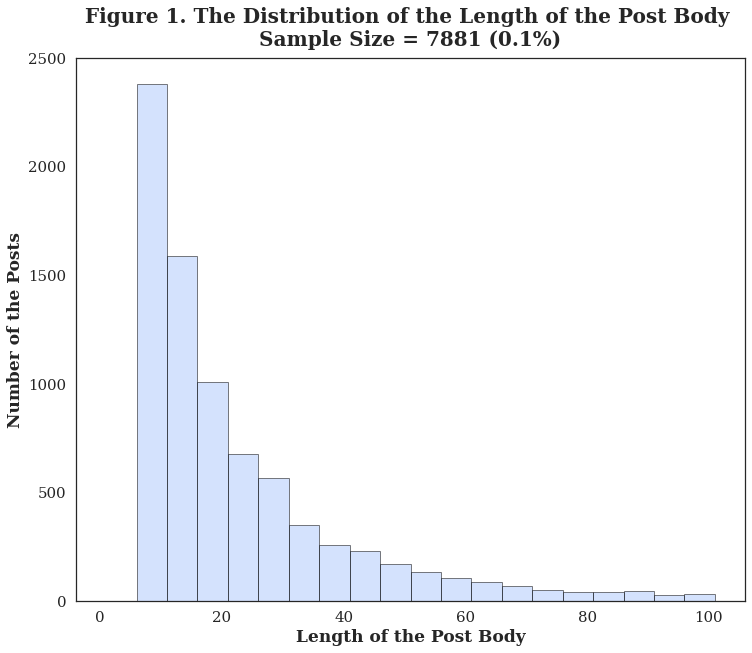

In [30]:
plt.figure(figsize=(12,10))
pal = sns.color_palette(palette="coolwarm", n_colors=2)[1::-1]
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})
plt.hist("len_body", data = df_small, bins = range(1,102,5), edgecolor="black", color=pal[1], alpha=0.5)

### Set a title, axis label, legend and rotate the xticks
plt.title(label="Figure 1. The Distribution of the Length of the Post Body \nSample Size = 7881 (0.1%)", fontsize = 20, fontweight = "bold", y = 1.01)
plt.xlabel(xlabel = "Length of the Post Body", fontsize = 17, fontweight = "bold")
plt.ylabel(ylabel = "Number of the Posts", fontsize = 17, fontweight = "bold")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

### Figure 2. Boxplot of "Post Length" for Premium or Umpremium Authors

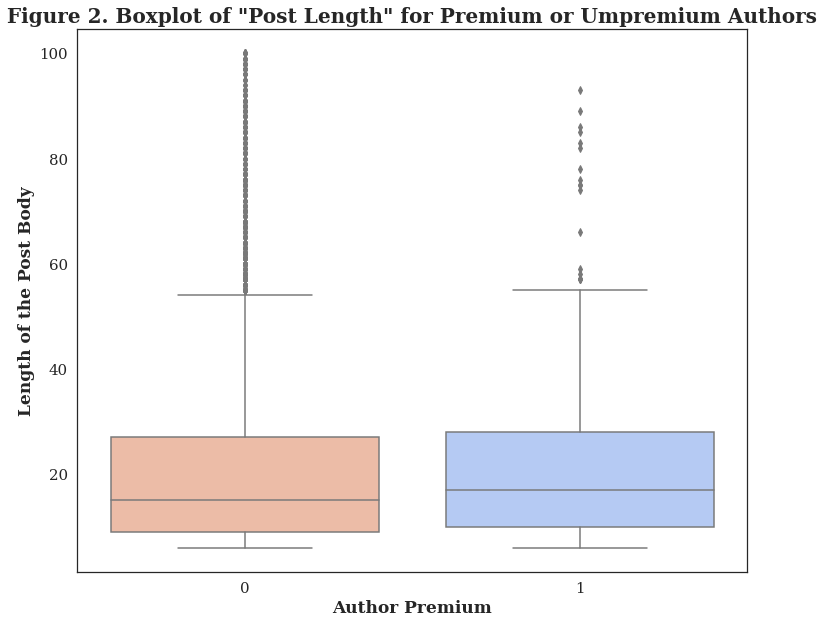

In [31]:
plt.figure(figsize=(12,10))
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})

ax = plt.axes() ## Create an ax
pal = sns.color_palette(palette="coolwarm", n_colors=2)[1::-1] ## Generate a palette
### Make the plot
sns.boxplot(x="author_premium", y="len_body", data=df_small, palette=pal)
plt.title("Figure 2. Boxplot of \"Post Length\" for Premium or Umpremium Authors", fontweight='bold', fontsize = 20) ## Set a title
plt.xlabel('Author Premium', fontweight='bold', fontsize=17) ## Set x axis labels
plt.ylabel('Length of the Post Body', fontweight='bold', fontsize=17) ## Set y axis labels
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

### Figure 3. Lineplot of the Trend of Number of Posts Every Month

In [32]:
df_line_plot = df_small[["author","month"]].groupby("month").count().reset_index().rename(columns={"author":"num_posts"})

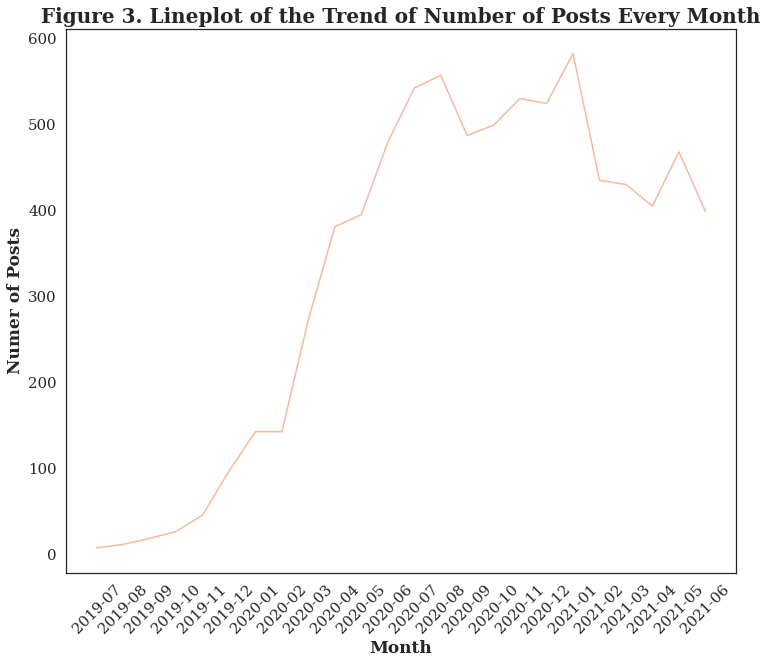

In [33]:
plt.figure(figsize=(12,10))
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})

ax = plt.axes() ## Create an ax
pal = sns.color_palette(palette="coolwarm", n_colors=2)[1::-1] ## Generate a palette
### Make the plot
# use the plot function
plt.plot(df_line_plot.month, df_line_plot.num_posts, color=pal[0])

plt.title("Figure 3. Lineplot of the Trend of Number of Posts Every Month", fontweight='bold', fontsize = 20) ## Set a title
plt.xlabel('Month', fontweight='bold', fontsize=17) ## Set x axis labels
plt.ylabel('Numer of Posts', fontweight='bold', fontsize=17) ## Set y axis labels
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15)

# show the graph
plt.show()

### Figure 4. KDE Plot Between the Post Length and Score

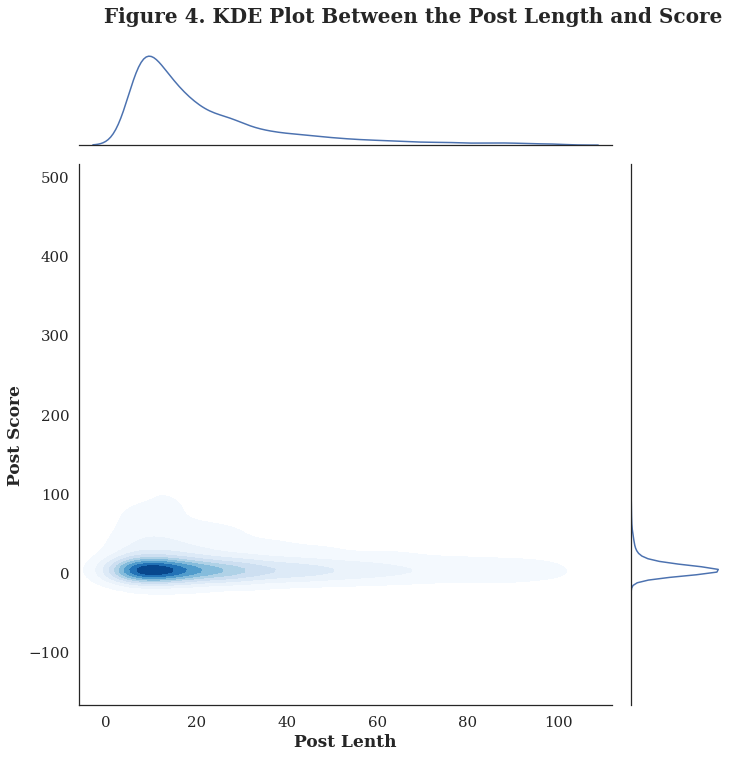

In [34]:
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif','xtick.labelsize': 15, 'ytick.labelsize': 15})
pal = sns.color_palette(palette="coolwarm", n_colors=2)[1::-1] ## Generate a palette


ax = sns.jointplot(x="len_body", y="score", data = df_small[df_small.score <=500], cmap="Blues", shade=True, kind='kde', height = 10)
#ax = sns.kdeplot(x="len_body", y="score", data = df_small[df_small.score <=500], cmap="Blues", shade=True, height=10)
ax.set_axis_labels(xlabel='Post Lenth', ylabel='Post Score',  fontweight='bold', fontsize=17) ## Set x axis labels

plt.title("Figure 4. KDE Plot Between the Post Length and Score", fontweight='bold', fontsize = 20, y=1.25, loc="right") ## Set a title

# show the graph
plt.show()

### Figure 5. Radar Plot of the Average Score of Different Authors' Flairs

In [35]:
df_radar = df_small.groupby("author_flair_text").mean().reset_index()

In [36]:
from math import pi
# number of variable
categories = list(df_radar.author_flair_text)
N = len(categories)

# Repeat the first value to close the circular graph:
values = df_radar.score.values.flatten().tolist()
values += values[:1]
values

# Divide the plot / number of variable to get the angles of axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

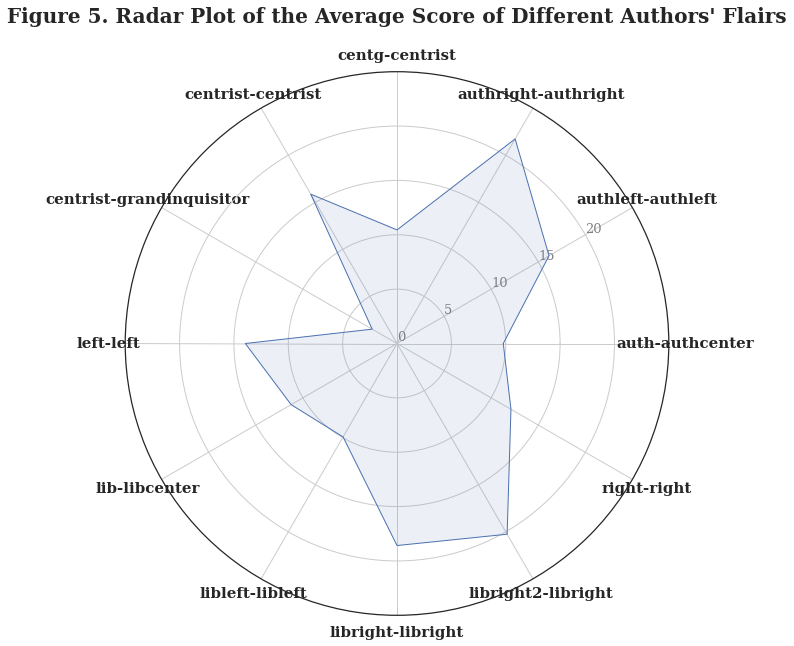

In [37]:
plt.figure(figsize=(12,10))
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, fontsize=15, rotation = 45, fontweight="bold")

# Draw ylabels
ax.set_rlabel_position(30)
plt.yticks([0,5,10,15,20], ["0","5","10","15","20"], color="grey", size=13)
plt.ylim(0,25)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)
plt.title("Figure 5. Radar Plot of the Average Score of Different Authors' Flairs", fontweight='bold', fontsize = 20, y=1.08) ## Set a title

# Show the graph
plt.show()

## 5. Summary Table
### Answer: 
1. Summary table of average score, number of posts, and average post length by month. 
2. Summary table of number of authors, number of premium users, number of posts, average post length, and average score by author flair type.
3. Summary table of number of posts, average post length, average score, average controversiality, number of send_replies, number of no_follow, and average gilded by score group.

In [38]:
summary_1 = df_f_use.groupBy("month").agg({"*":"count", "score":"mean", "len_body":"mean"}).orderBy("month").toPandas()
summary_1 = summary_1.rename(columns={"avg(score)":"avg_score", "count(1)":"num_post", "avg(len_body)":"avg_post_len"})
summary_1

,month,avg_score,num_post,avg_post_len
0,2019-07,12.769485,9071,21.294345
1,2019-08,12.393018,13063,20.728623
2,2019-09,12.988443,16527,20.041145
3,2019-10,12.272659,34677,20.232085
4,2019-11,13.025503,51367,19.968501
5,2019-12,14.409641,92830,19.189734
6,2020-01,14.623759,153545,19.662008
7,2020-02,14.124336,166806,20.661757
8,2020-03,15.162984,256694,20.698298
9,2020-04,14.894150,378431,21.677532


In [39]:
summary_2 = df_f_use.groupBy("author_flair_text").agg(f.countDistinct("author_fullname"), 
                                          f.countDistinct(f.when(f.col("author_premium")==1, f.col("author_fullname"))), 
                                          f.count("author"), 
                                          f.mean("len_body"), 
                                          f.mean("score")).toPandas()

summary_2 = summary_2.rename(columns = {"count(author_fullname)":"num_author",
                                        "count(CASE WHEN (author_premium = 1) THEN author_fullname END)":"num_premium_author", 
                                        "count(author)":"num_post", 
                                        "avg(len_body)":"avg_post_len", 
                                        "avg(score)":"avg_score"})

summary_2

,author_flair_text,num_author,num_premium_author,num_post,avg_post_len,avg_score
0,auth-authcenter,11119,361,741710,23.168892,13.481024
1,authright-authright,13370,431,624875,20.531609,17.003356
2,right-right,14897,627,621542,21.865941,16.465785
3,left-left,20502,1091,641302,23.958944,11.695906
4,authleft-authleft,9715,411,415993,21.832906,13.183563
5,centrist-centrist,23233,1162,858226,22.452826,15.365104
6,lib-libcenter,28843,1384,924146,22.249879,15.330648
7,libright2-libright,5172,258,288570,20.092279,17.275860
8,,5,0,268,19.067164,8.253731
9,centrist-grandinquisitor,1,1,7601,20.301539,11.050914


In [40]:
summary_3 = df_f_use.groupBy("score_group").agg(f.count("author"), 
                                                f.mean("len_body"), 
                                                f.mean("score"),
                                                f.mean("controversiality"),
                                                f.sum("send_replies"),
                                                f.sum("no_follow"),
                                                f.mean("gilded")).toPandas()

summary_3 = summary_3.rename(columns={"count(author)":"num_post", 
                                      "avg(len_body)":"avg_post_len", 
                                      "avg(score)":"avg_score",
                                      "avg(controversiality)":"avg_controversiality",
                                      "sum(send_replies)":"num_send_replies",
                                      "sum(no_follow)":"num_no_follow",
                                      "avg(gilded)":"avg_gilded"})

summary_3

,score_group,num_post,avg_post_len,avg_score,avg_controversiality,num_send_replies,num_no_follow,avg_gilded
0,high_positive,414067,20.455158,186.952853,0.000111,413081,41321,0.001128
1,low_negative,349852,25.814530,-6.015984,0.203635,347914,314203,0.000049
2,low_positive,6985752,22.066004,6.023919,0.020595,6966040,4015353,0.000026
3,high_negative,3966,24.391074,-81.109178,0.003026,3931,3563,0.001009


## 6. Create Dummy Variables
### Answer: 
Dummy variables including `covid`, `election`, `economics`, `finance`, `gender`, and `race` were created using regex to eveluate whether the post contains the dummy variables, and summary tables were maded based on these dummy variables. 

In [41]:
df_f_use = df_f_use.withColumn("covid", f.when(df_f_use["body"].rlike("(?i)covid|coronavirus|pandemic"), 1).otherwise(0))

In [42]:
df_f_use = df_f_use.withColumn("election", f.when(df_f_use["body"].rlike("(?i)election"), 1).otherwise(0))

In [43]:
df_f_use = df_f_use.withColumn("economics", f.when(df_f_use["body"].rlike("(?i)econom"), 1).otherwise(0))

In [44]:
df_f_use = df_f_use.withColumn("finance", f.when(df_f_use["body"].rlike("(?i)financ|stock"), 1).otherwise(0))

In [45]:
df_f_use = df_f_use.withColumn("gender_equality", f.when(df_f_use["body"].rlike("(?i)gender"), 1).otherwise(0))

In [46]:
df_f_use = df_f_use.withColumn("racial_equality", f.when(df_f_use["body"].rlike("(?i)black|racis|blm"), 1).otherwise(0))

In [47]:
df_f_use.groupBy("covid").count().show()

+-----+-------+
|covid|  count|
+-----+-------+
|    1|  34384|
|    0|7719253|
+-----+-------+



In [48]:
df_f_use.groupBy("election").count().show()

+--------+-------+
|election|  count|
+--------+-------+
|       1|  44198|
|       0|7709439|
+--------+-------+



In [49]:
df_f_use.groupBy("economics").count().show()

+---------+-------+
|economics|  count|
+---------+-------+
|        1| 120068|
|        0|7633569|
+---------+-------+



In [50]:
df_f_use.groupBy("finance").count().show()

+-------+-------+
|finance|  count|
+-------+-------+
|      1|  29025|
|      0|7724612|
+-------+-------+



In [51]:
df_f_use.groupBy("gender_equality").count().show()

+---------------+-------+
|gender_equality|  count|
+---------------+-------+
|              1|  59921|
|              0|7693716|
+---------------+-------+



In [52]:
df_f_use.groupBy("racial_equality").count().show()

+---------------+-------+
|racial_equality|  count|
+---------------+-------+
|              1| 271779|
|              0|7481858|
+---------------+-------+



## 7. Join External Data
### Answer:
Here, COVID data and stock price daily data were collected and joined to the Reddit data. To find out the relationship between these variables, a correlation plot was maded. 

According to the plot, it can be recognized that number of posts and stock price, new COVID cases and number of posts are related. 

### COVID Data

In [53]:
df_covid = spark.read.csv('s3://yc910-labdata-2/covid_daily_case_us.csv')

In [54]:
df_covid.show(5)

+----------+------+-----+--------+----+----+------+
|       _c0|   _c1|  _c2|     _c3| _c4| _c5|   _c6|
+----------+------+-----+--------+----+----+------+
|2021-10-08|106296|92622|44217318|2196|1465|711020|
|2021-10-07|104158|94334|44110478|1534|1418|708784|
|2021-10-06|105726|96272|44005527|1860|1440|707234|
|2021-10-05|103230|98006|43889265|1975|1462|705323|
|2021-10-04| 73127|99278|43785797| 981|1442|703348|
+----------+------+-----+--------+----+----+------+
only showing top 5 rows



In [55]:
df_covid = df_covid.withColumnRenamed("_c0","date")\
.withColumnRenamed("_c1","new_case")\
.withColumnRenamed("_c2","case_ma_7d")\
.withColumnRenamed("_c3","total_case")\
.withColumnRenamed("_c4","new_death")\
.withColumnRenamed("_c5","death_ma_7d")\
.withColumnRenamed("_c6","total_death")

In [56]:
df_covid.show(5)

+----------+--------+----------+----------+---------+-----------+-----------+
|      date|new_case|case_ma_7d|total_case|new_death|death_ma_7d|total_death|
+----------+--------+----------+----------+---------+-----------+-----------+
|2021-10-08|  106296|     92622|  44217318|     2196|       1465|     711020|
|2021-10-07|  104158|     94334|  44110478|     1534|       1418|     708784|
|2021-10-06|  105726|     96272|  44005527|     1860|       1440|     707234|
|2021-10-05|  103230|     98006|  43889265|     1975|       1462|     705323|
|2021-10-04|   73127|     99278|  43785797|      981|       1442|     703348|
+----------+--------+----------+----------+---------+-----------+-----------+
only showing top 5 rows



In [57]:
df_covid = df_covid.withColumn("date", f.to_date("date"))\
.withColumn("new_case",f.col("new_case").cast("int"))\
.withColumn("case_ma_7d",f.col("case_ma_7d").cast("int"))\
.withColumn("total_case",f.col("total_case").cast("int"))\
.withColumn("new_death",f.col("new_death").cast("int"))\
.withColumn("death_ma_7d",f.col("death_ma_7d").cast("int"))\
.withColumn("total_death",f.col("total_death").cast("int"))

In [58]:
df_covid.printSchema()

root
 |-- date: date (nullable = true)
 |-- new_case: integer (nullable = true)
 |-- case_ma_7d: integer (nullable = true)
 |-- total_case: integer (nullable = true)
 |-- new_death: integer (nullable = true)
 |-- death_ma_7d: integer (nullable = true)
 |-- total_death: integer (nullable = true)



In [59]:
df_covid = df_covid.filter(f.col("date") <= "2021-06-30")

### Stock Price Data

In [60]:
!~/miniconda/bin/pip install yfinance

In [61]:
import yfinance as yf

df_nq = yf.download('NQ=F', start='2019-07-01', end='2021-06-30')
df_nq = df_nq.drop(["Open", "High", "Low", "Close"], axis=1)
df_nq = df_nq.reset_index()
df_nq.columns = ["date", "nq_close", "nq_vol"]

[*********************100%***********************]  1 of 1 completed


In [62]:
df_nq = spark.createDataFrame(df_nq) 

In [63]:
df_nq = df_nq.withColumn("date", f.to_date("date"))

In [64]:
df_nq.show(5)

+----------+--------+------+
|      date|nq_close|nq_vol|
+----------+--------+------+
|2019-07-01|  7790.0|406594|
|2019-07-02| 7838.25|297574|
|2019-07-03|  7887.5|209604|
|2019-07-05|  7851.5|375287|
|2019-07-08|  7801.0|342228|
+----------+--------+------+
only showing top 5 rows



In [65]:
df_nq.printSchema()

root
 |-- date: date (nullable = true)
 |-- nq_close: double (nullable = true)
 |-- nq_vol: long (nullable = true)



In [66]:
df_f_agg = df_f_use.groupBy("date").agg({"*":"count", "score":"mean", "len_body":"mean"}).orderBy("date")\
.withColumnRenamed("avg(score)","avg_score")\
.withColumnRenamed("count(1)","num_posts")\
.withColumnRenamed("avg(len_body)","avg_post_len")

In [67]:
df_f_agg.show(5)

+----------+------------------+---------+------------------+
|      date|         avg_score|num_posts|      avg_post_len|
+----------+------------------+---------+------------------+
|2019-07-01|10.490196078431373|      153|21.464052287581698|
|2019-07-02| 7.518716577540107|      374| 22.61764705882353|
|2019-07-03|  6.08029197080292|      137| 19.45985401459854|
|2019-07-04|15.450292397660819|      171|18.362573099415204|
|2019-07-05|12.823834196891191|      193|16.792746113989637|
+----------+------------------+---------+------------------+
only showing top 5 rows



In [68]:
df_f_join = df_f_agg.join(df_covid, how="left", on="date").join(df_nq, how="left", on="date").orderBy("date")

In [69]:
df_f_join.show(5)

+----------+------------------+---------+------------------+--------+----------+----------+---------+-----------+-----------+--------+------+
|      date|         avg_score|num_posts|      avg_post_len|new_case|case_ma_7d|total_case|new_death|death_ma_7d|total_death|nq_close|nq_vol|
+----------+------------------+---------+------------------+--------+----------+----------+---------+-----------+-----------+--------+------+
|2019-07-01|10.490196078431373|      153|21.464052287581698|    null|      null|      null|     null|       null|       null|  7790.0|406594|
|2019-07-02| 7.518716577540107|      374| 22.61764705882353|    null|      null|      null|     null|       null|       null| 7838.25|297574|
|2019-07-03|  6.08029197080292|      137| 19.45985401459854|    null|      null|      null|     null|       null|       null|  7887.5|209604|
|2019-07-04|15.450292397660819|      171|18.362573099415204|    null|      null|      null|     null|       null|       null|    null|  null|
|2019-

In [70]:
df_join = df_f_join.toPandas().drop(["date", "case_ma_7d", "total_case", "new_death", "death_ma_7d", "total_death"], axis=1)

In [71]:
df_join.head()

,avg_score,num_posts,avg_post_len,new_case,nq_close,nq_vol
0,10.490196,153,21.464052,NaN,7790.00,406594.0
1,7.518717,374,22.617647,NaN,7838.25,297574.0
2,6.080292,137,19.459854,NaN,7887.50,209604.0
3,15.450292,171,18.362573,NaN,NaN,NaN
4,12.823834,193,16.792746,NaN,7851.50,375287.0


<Figure size 1440x1080 with 0 Axes>

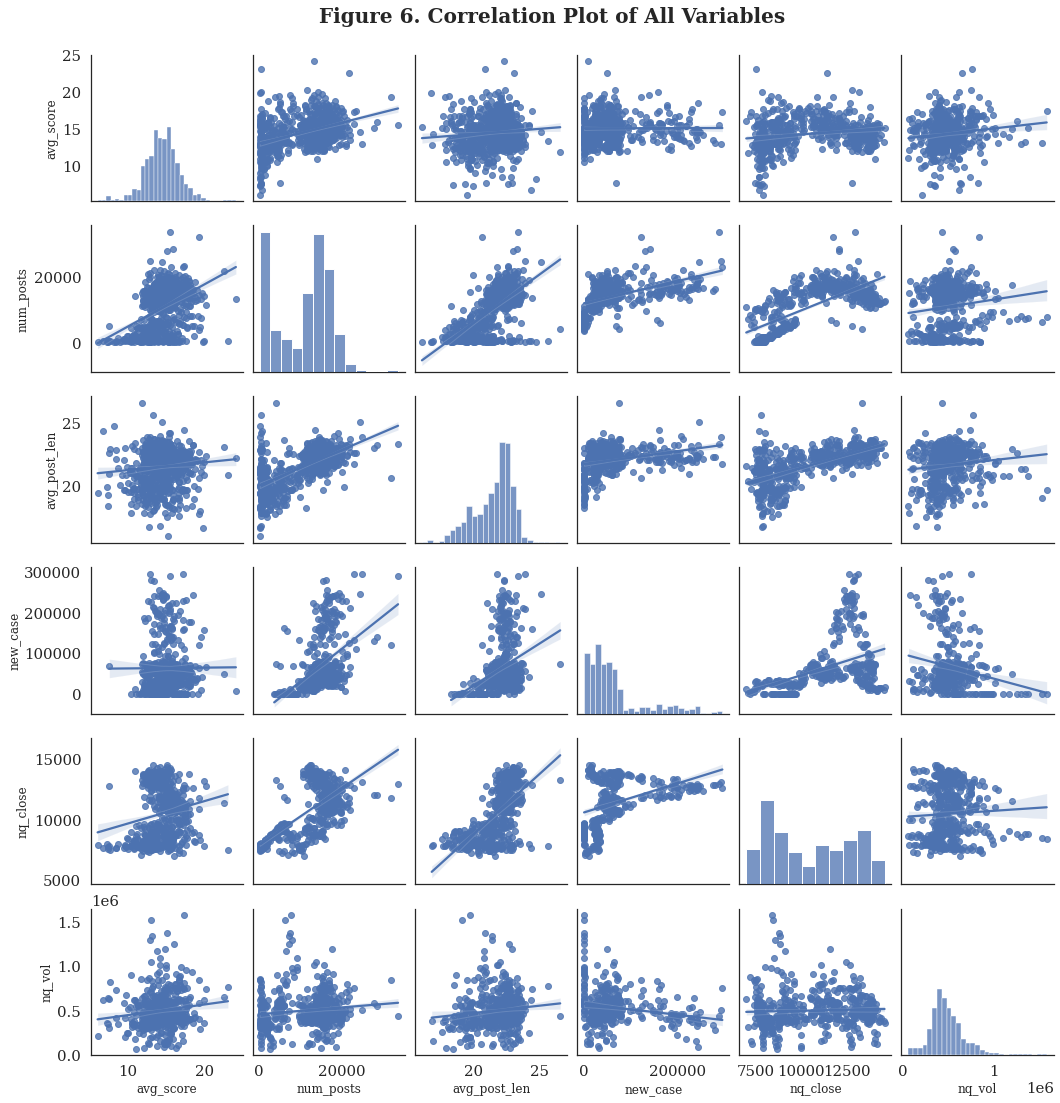

In [72]:
## Plot the figure
plt.figure(figsize=(20,15)) ## Fig size
sns.set_style("white") ## Set a style
pal = sns.color_palette(palette="coolwarm", n_colors=2)[1::-1] ## Generate a color_palette
plt.rcParams.update({'font.family':'serif'}) ## Set a font family

### Make the plot
ax = sns.pairplot(df_join, kind='reg', palette=pal[1])

### Set title, axis labels and legend
plt.title(label = "Figure 6. Correlation Plot of All Variables", fontsize = 20, fontweight = "bold", y = 7, x = -2.3)
plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)
plt.rc('axes', titlesize=15, labelsize=17)

plt.show()

## 8. Summary
1. Most of the posts (over 60%) are less than 20 words.
2. There is not a significant difference of post length between the premium authors and the non-premium authors. 
3. After the COVID (2020-01), the number of posts every month started to increase fast. 
4. The length of posts and the score of posts are not likely to have a significan relationship.
5. The posts from right related `author_flair` type tend to have a higher score. 
6. According to the plot, it can be recognized that number of posts and stock price, new COVID cases and number of posts are related. 

In [73]:
spark.stop()